In [1]:
import torch
import sklearn
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import time
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import math
import matplotlib.pyplot as plt
import json
import math


In [2]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [3]:
working_dir = os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\\New_SPT\MS\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name

excel_name = 'MS.xlsx' 

source_table = pd.read_excel(excel_path + excel_name, sheet_name='raw_data')

source_table.keys()

c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code


Index(['l_ph_hip', 'l_fy', 'l_grf_w_norm', 'r_ph_hip', 'r_fy', 'r_grf_w_norm',
       'strike ', 'perc'],
      dtype='object')

In [4]:
source_table = source_table.loc[source_table["perc"]!= 100]

In [5]:
source_table                  

,l_ph_hip,l_fy,l_grf_w_norm,r_ph_hip,r_fy,r_grf_w_norm,strike,perc
0,1.667017,-0.127046,-0.387842,0.012451,2.105842,0.608077,3,0.925926
1,1.657999,-0.242379,-0.335895,-0.061576,2.164800,0.586773,4,1.388889
2,1.647816,-0.158323,-0.275105,-0.129950,2.168604,0.560664,5,1.851852
3,1.636403,0.049340,-0.206739,-0.190785,2.159095,0.529550,6,2.314815
4,1.623707,0.350380,-0.132497,-0.243569,2.366401,0.493235,7,2.777778
...,...,...,...,...,...,...,...,...
191780,-0.724640,0.000611,-0.502154,1.164687,1.537902,0.534692,220,97.767857
191781,-0.736842,0.000611,-0.502154,1.168225,1.629057,0.536549,221,98.214286
191782,-0.748785,0.032818,-0.502154,1.171898,1.668123,0.536308,222,98.660714
191783,-0.760126,0.003743,-0.502154,1.175569,1.671843,0.533783,223,99.107143


In [6]:
x = source_table
x = x.drop(['perc'], axis=1)
scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc')
y = source_table[["X","Y"]]
y

,X,Y
0,0.998308,0.058145
1,0.996195,0.087156
2,0.993238,0.116093
3,0.989442,0.144932
4,0.984808,0.173648
...,...,...
191780,0.990181,-0.139790
191781,0.993712,-0.111964
191782,0.996461,-0.084051
191783,0.998427,-0.056070


In [7]:
source_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190964 entries, 0 to 191784
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      190964 non-null  float64
 1   l_fy          190964 non-null  float64
 2   l_grf_w_norm  190964 non-null  float64
 3   r_ph_hip      190964 non-null  float64
 4   r_fy          190964 non-null  float64
 5   r_grf_w_norm  190964 non-null  float64
 6   strike        190964 non-null  int64  
 7   perc          190964 non-null  float64
 8   X             190964 non-null  float64
 9   Y             190964 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 16.0 MB


In [8]:
source_table.describe().T

,count,mean,std,min,25%,50%,75%,max
l_ph_hip,190964.0,2.655977e-03,0.999405,-1.296948,-0.948217,-4.015439e-01,1.003906,1.697882
l_fy,190964.0,8.192141e-05,1.002154,-3.879083,-0.228696,6.112203e-04,0.331313,3.019709
l_grf_w_norm,190964.0,2.027575e-03,0.449913,-0.504270,-0.502154,1.496331e-01,0.427564,0.847772
r_ph_hip,190964.0,-1.645616e-03,1.000377,-1.362603,-0.935733,-3.995019e-01,0.998653,1.546127
r_fy,190964.0,-7.252362e-03,0.995786,-3.585783,-0.222369,-3.147295e-02,0.373357,3.189844
r_grf_w_norm,190964.0,-2.339749e-03,0.449548,-0.517493,-0.514522,1.515278e-01,0.416745,0.868919
strike,190964.0,1.168611e+02,67.730333,1.000000,58.000000,1.160000e+02,174.000000,282.000000
perc,190964.0,4.978582e+01,28.867040,0.000000,24.782609,4.978355e+01,74.786325,100.000000
X,190964.0,-1.046924e-05,0.707105,-1.000000,-0.707107,-1.836970e-16,0.707107,1.000000
Y,190964.0,-2.865858e-07,0.707112,-1.000000,-0.707107,0.000000e+00,0.707107,1.000000


In [9]:
def decompose_bike_sharing_demand(df, share_type=['X'], samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

In [10]:
#decompose_bike_sharing_demand(source_table, samples=1000, period=200)

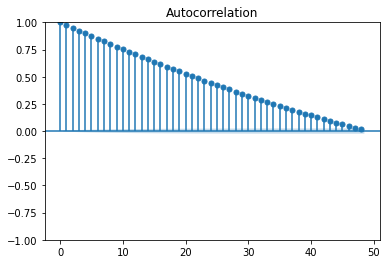

In [11]:
plot_acf(source_table['perc'].values, lags=48)
plt.show()

In [12]:
data_x = source_table.drop(["perc", "X", "Y"], axis = 1)
target = source_table[["X", "Y"]]

data_x.info()
target.info()

scaler = MinMaxScaler()
data = scaler.fit_transform(data_x)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 190964 entries, 0 to 191784
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      190964 non-null  float64
 1   l_fy          190964 non-null  float64
 2   l_grf_w_norm  190964 non-null  float64
 3   r_ph_hip      190964 non-null  float64
 4   r_fy          190964 non-null  float64
 5   r_grf_w_norm  190964 non-null  float64
 6   strike        190964 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 11.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 190964 entries, 0 to 191784
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       190964 non-null  float64
 1   Y       190964 non-null  float64
dtypes: float64(2)
memory usage: 4.4 MB


In [13]:
ratio = 0.8
training_cutoff = math.floor(ratio * len(source_table))

training_data = data[0:training_cutoff]
training_target = target[0:training_cutoff].values

validation_data = data[training_cutoff:-1]
validation_target = target[training_cutoff:-1].values

print(training_data.shape)
print(training_target.shape)
print(validation_data.shape)
print(validation_target.shape)

(152771, 7)
(152771, 2)
(38192, 7)
(38192, 2)


In [14]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(training_data, training_target, look_back, fore_cast)
validation_x, validation_y = convert_data(validation_data, validation_target, look_back, fore_cast)
 

In [16]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

(152760, 10, 7)
(152760, 2)
(38181, 10, 7)
(38181, 2)


In [17]:
training_target[10:]

array([[ 0.93969262,  0.34202014],
       [ 0.92934752,  0.36920615],
       [ 0.91821611,  0.39607977],
       ...,
       [-0.27366299,  0.96182564],
       [-0.29895682,  0.95426664],
       [-0.3240423 ,  0.94604259]])

In [18]:
print(train_y)

[[ 0.92934752  0.36920615]
 [ 0.91821611  0.39607977]
 [ 0.90630779  0.42261826]
 ...
 [-0.27366299  0.96182564]
 [-0.29895682  0.95426664]
 [-0.3240423   0.94604259]]


In [19]:
print(train_x.shape)
print(validation_x.shape)

(152760, 10, 7)
(38181, 10, 7)


In [20]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        curLR = optimizer.lr
        return curLR
    return lr


In [21]:
epochs = 30
batch_size = 64                                                                    
learning_rate = 1e-2

# learning rate scheduler
use_lr_scheduler = True
lr_factor = 0.5
lr_patience = 8
lr_threshold = 0.01
lr_min_rate = 1e-6

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model = Sequential()
model.add(LSTM(64, input_shape=(look_back, train_x.shape[2]), return_sequences = True, dropout=0.1))
#model.add(LSTM(64, return_sequences = True))
model.add(LSTM(32))
model.add(Dense(2))


print(model.summary())

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', get_lr_metric(optimizer), 'mae','mse'])
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=monitor,verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            18432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 30,914
Trainable params: 30,914
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
2387/2387 [==============================] - 28s 10ms/step - loss: 0.0113 - accuracy: 0.9824 - lr: 0.0100 - mae: 0.0681 - mse: 0.0113
Epoch 2/30
2387/2387 [==============================] - 26s 11ms/step - loss: 0.0041 - accuracy: 0.9853 - lr: 0.0100 - mae: 0.0445 - mse: 0.0041
Epoch 3/30
2387/2387 

In [22]:
#model.save('lstm_full.hdf5')                        

In [23]:
# make predictions
trainPredict = model.predict(train_x)
testPredict = model.predict(validation_x)

1194/1194 [==============================] - 4s 3ms/step


In [24]:
trainPredict.shape

(152760, 2)

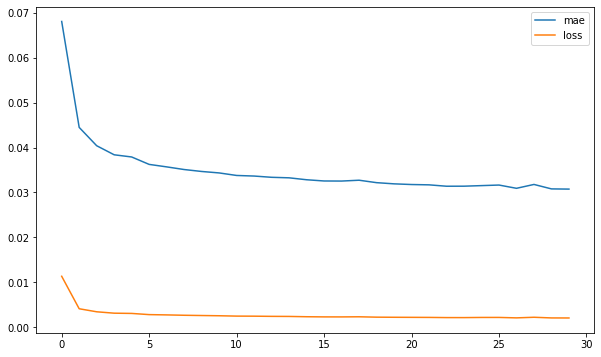

In [25]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

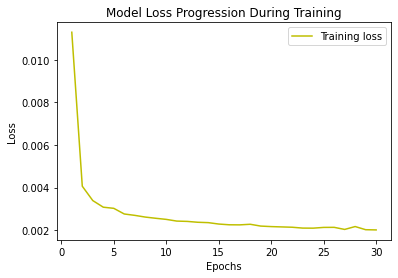

In [26]:
loss= history.history['loss']

epochs=range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')

plt.title('Model Loss Progression During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

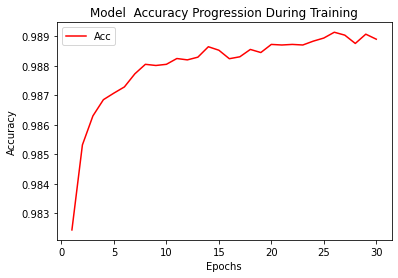

In [27]:

accuracy=history.history['accuracy']
epochs=range(1,len(loss)+1)
plt.plot(epochs,accuracy, 'r', label='Acc')
plt.title('Model  Accuracy Progression During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [28]:
validation_x[:].shape

(38181, 10, 7)

In [29]:
validation_data.shape

(38192, 7)

In [30]:
v = validation_data[11:]
v.shape

(38181, 7)

In [31]:

test_data = np.reshape(validation_x[:],(validation_x.shape[0], validation_x[:].shape[1], validation_x[:].shape[2]))

In [32]:
test_data.shape

(38181, 10, 7)

In [33]:
test = model.predict(test_data)
test

1194/1194 [==============================] - 4s 3ms/step


array([[-0.5781302 ,  0.8055378 ],
       [-0.5966793 ,  0.79266536],
       [-0.6133361 ,  0.7802354 ],
       ...,
       [ 0.8985909 , -0.4225172 ],
       [ 0.9098956 , -0.40210673],
       [ 0.91849995, -0.38100582]], dtype=float32)

In [34]:
testPredict.shape

(38181, 2)

In [35]:
trainPredict.shape

(152760, 2)

In [36]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.12 RMSE
Test Score: 0.12 RMSE


In [37]:
#trainPredictPlot = np.empty_like(target)
#trainPredictPlot[:, :] = np.nan
#trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
#testPredictPlot = np.empty_like(target)
#testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(target)-(look_back-fore_cast), :] = testPredict
# plot baseline and predictions

#fig=plt.figure(figsize=(35,15))
#plt.plot(trainPredictPlot[57000:])
#plt.plot(testPredictPlot[57000:])
#plt.show()


In [38]:
#x_test = scaler.inverse_transform(testPredict)


#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))



In [103]:
x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  if ((pred[iter] >= 95) & (x_test[iter][6] <= 10)):
    pred[iter] = pred[iter] - 100
  
  if ((pred[iter] <= 5) & (x_test[iter][6] >= 200)):
    pred[iter] = 100 - pred[iter]

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [104]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  

In [105]:
correct = 0
for iter in range(len(actual)):
  if (abs(actual[iter] - pred[iter]) <= 5):
    correct+=1

print(correct)
print(len(actual))

print("Precision: ", correct * 100/len(actual))

35158
38181
Precision:  92.08244938582017


In [106]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / len(actual)
rmse = math.sqrt(rmse)
print(length)
print(rmse)

37997
2.7990542532915694


In [107]:
rmse_perc = np.sqrt(mean_squared_error(actual, pred))
print('Test Score: %.2f RMSE' % (rmse_perc))

Test Score: 7.05 RMSE


Text(0, 0.5, 'Percentage (%)')

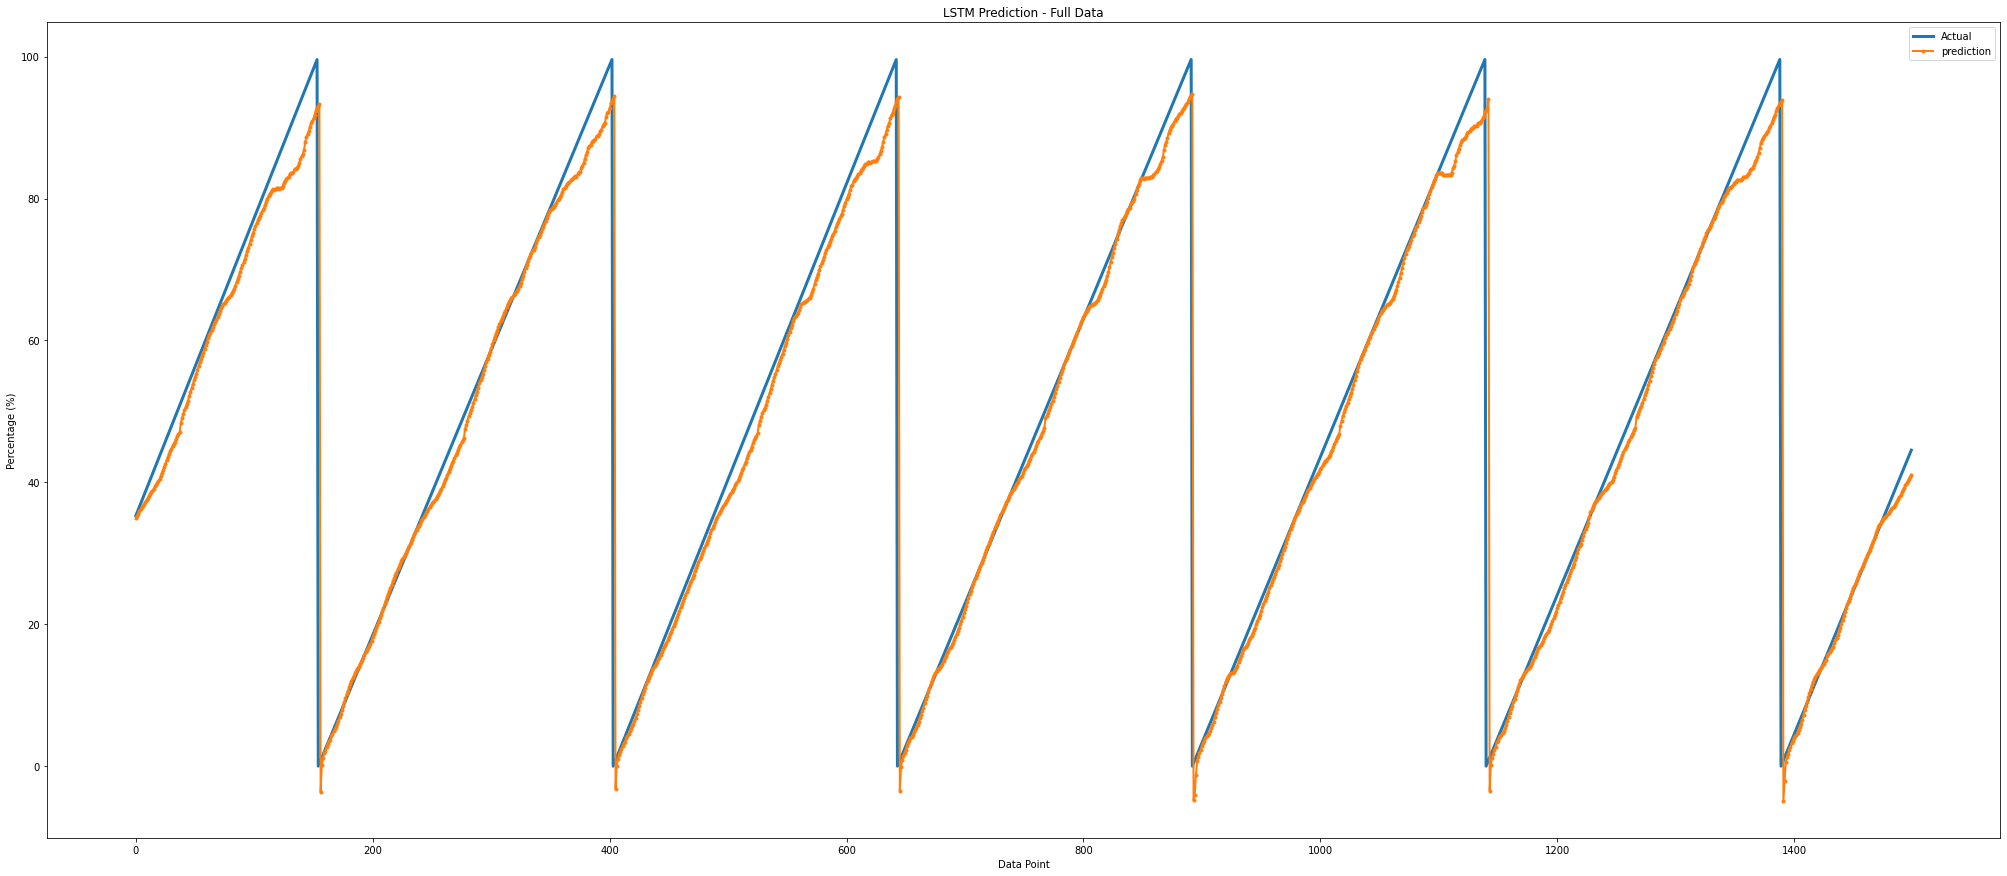

In [108]:
#plt.plot(Y[52272:52470],LShank[52272:52470],'--',label='Actual')
#plt.plot(pred,LShank,'--',label='prediction')
fig=plt.figure(figsize=(35,15))

plt.plot(actual[0:1500],'-',label='Actual', linewidth = 3)
plt.plot(pred[0:1500],'.-',label='prediction', linewidth = 2)



#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('LSTM Prediction - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

Text(0.5, 1.0, 'Actual vs Prediction')

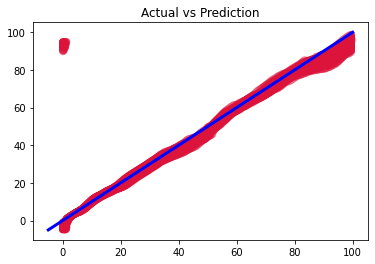

In [109]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

**TESTING USING OTHER DATA**

In [110]:
test_excel_name= 'MS_4.xlsx' 

test_table = pd.read_excel(excel_path + test_excel_name, sheet_name='raw_data')
encode_gait_percentage(test_table, 'perc')

test_table.keys()


Index(['l_ph_hip', 'l_fy', 'l_grf_w_norm', 'r_ph_hip', 'r_fy', 'r_grf_w_norm',
       'strike ', 'perc', 'X', 'Y'],
      dtype='object')

In [111]:
test_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95813 entries, 0 to 95812
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   l_ph_hip      95813 non-null  float64
 1   l_fy          95813 non-null  float64
 2   l_grf_w_norm  95813 non-null  float64
 3   r_ph_hip      95813 non-null  float64
 4   r_fy          95813 non-null  float64
 5   r_grf_w_norm  95813 non-null  float64
 6   strike        95813 non-null  int64  
 7   perc          95813 non-null  float64
 8   X             95813 non-null  float64
 9   Y             95813 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 7.3 MB


In [112]:
test_table = test_table.loc[test_table["perc"]!= 100]

In [113]:
data_x_test = test_table.drop(["perc", "X", "Y"], axis = 1)
target_test = test_table[["X", "Y"]]

scaler2 = MinMaxScaler()
data_test = scaler2.fit_transform(data_x_test)


In [114]:
print(data_test.shape)
print(target_test.shape)

(95400, 7)
(95400, 2)


In [115]:
target_test=target_test.values
type(target_test)

numpy.ndarray

In [116]:
look_back = 10
fore_cast = 1

test_x, test_y = convert_data(data_test, target_test, look_back, fore_cast)

In [117]:
d2 = data_test[11:]
d2.shape

(95389, 7)

In [118]:
test_new = model.predict(test_x)

2981/2981 [==============================] - 9s 3ms/step


In [119]:
test_new.shape

(95389, 2)

In [120]:
score = np.sqrt(mean_squared_error(test_y, test_new))
print('Test Score: %.3f RMSE' % (score))

Test Score: 0.096 RMSE


In [121]:
#predict = np.zeros((len(test_new),1))

#for iter in range(len(test_new)):
#  x = test_new[iter][0]
##  y = test_new[iter][1]
#  predict[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


In [122]:
x_test = scaler.inverse_transform(d2)

predict = np.zeros((len(test_new),1))

for iter in range(len(test_new)):
  x = test_new[iter][0]
  y = test_new[iter][1]
  predict[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  if ((predict[iter] >= 95) and (x_test[iter][6] <= 50)):
    predict[iter] = predict[iter] - 100
  
  if ((predict[iter] <= 5) and (x_test[iter][6] >= 180)):
    predict[iter] = 100 - predict[iter]

#pred1=pd.DataFrame(pred).sort_index().reset_index()

In [123]:
actual2 = np.zeros((len(test_y),1))

for iter in range(len(test_y)):
  x =test_y[iter][0]
  y =test_y[iter][1]
  actual2[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [124]:
rmse = 0
length = len(actual2)
for i in range(len(actual2)):
  if abs (predict[i] - actual2[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(predict[i] - actual2[i], 2)
rmse = rmse / len(actual2)
rmse = math.sqrt(rmse)
print(length)
print(rmse)

95294
2.15992467140475


In [138]:
correct = 0
for iter in range(len(actual2)):
  if (abs(actual2[iter] - predict[iter]) <= 5):
    correct+=1

print(correct)
print(len(actual2))

print("Precision: ", correct * 100/len(actual2))

91713
95389
Precision:  96.14630617786118


In [126]:
score = np.sqrt(mean_squared_error(actual2, predict))
print('Test Score: %.2f RMSE' % (score))

Test Score: 3.66 RMSE


Text(0, 0.5, 'Percentage (%)')

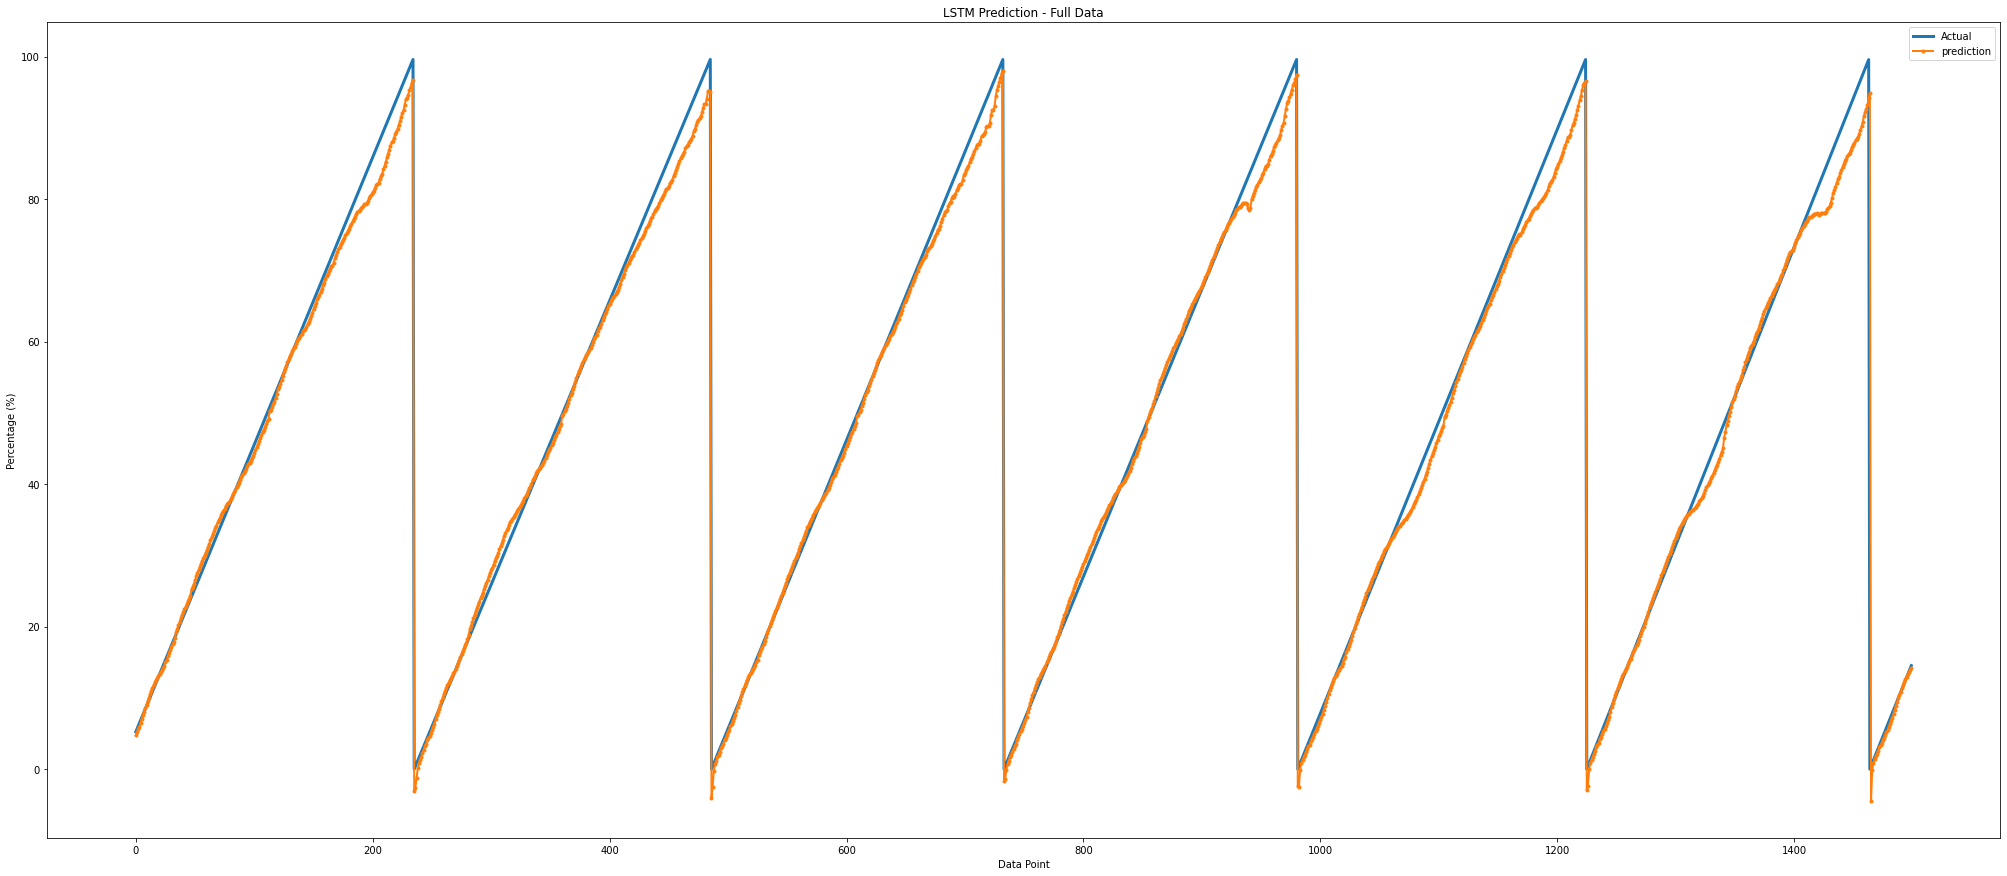

In [127]:
#plt.plot(Y[52272:52470],LShank[52272:52470],'--',label='Actual')
#plt.plot(pred,LShank,'--',label='prediction')
fig=plt.figure(figsize=(35,15))

plt.plot(actual2[0:1500],'-',label='Actual', linewidth = 3)
plt.plot(predict[0:1500],'.-',label='prediction', linewidth = 2)



#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('LSTM Prediction - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

Text(0.5, 1.0, 'Actual vs Prediction')

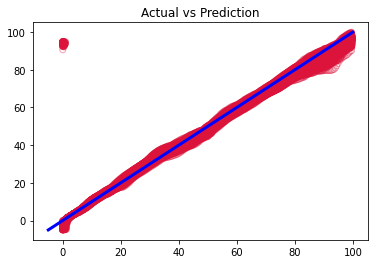

In [128]:
plt.scatter(actual2, predict, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(predict), max(actual2))
p2 = min(min(predict), min(actual2))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

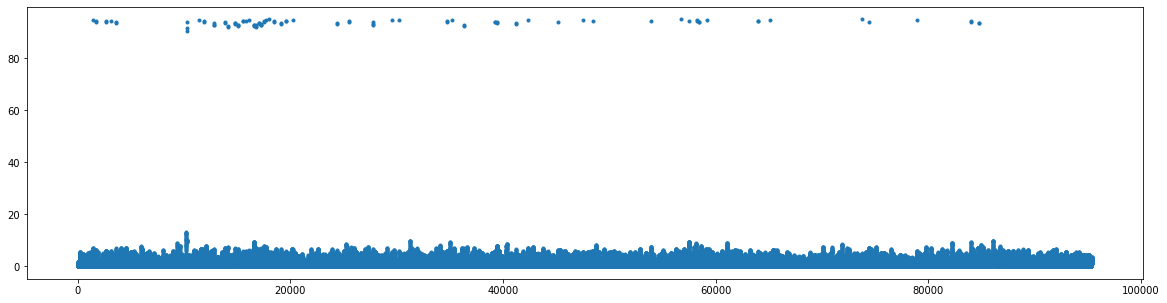

In [129]:
fig=plt.figure(figsize=(20,5))
dif = abs(actual2-predict)

plt.plot(dif,'.')


In [130]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [131]:
#class PolicyDataset(Dataset):
#    def __init__(self, data, target, transform=None):
#        self.data = data
#        self.target = target
        #self.label_split_idx = label_split_idx # not sure if splitting in dataset or in network is better idea.
        #self.use_cuda_if_avaiable = use_cuda_if_avaiable

#        return 
#    def __len__(self):
#        return self.data.shape[0]

#    def __getitem__(self, idx):
#        return self.data[idx, ], self.target[idx, ]

#training_dataset = PolicyDataset(training_data, training_target)
#validation_dataset = PolicyDataset(validation_data, validation_target)


In [132]:
#class LSTM(nn.Module):
#    def __init__(self, hidden_layers=64):
#        super(LSTM, self).__init__()
#        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
#        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
#        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
#        self.linear = nn.Linear(self.hidden_layers, 2)
        
#    def forward(self, y, future_preds=0):
#        outputs, n_samples = [], y.size(0)
#        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
#        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
#        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
#        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
#        for time_step in y.split(1, dim=1):
            # N, 1
#            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
#            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
#            output = self.linear(h_t2) # output from the last FC layer
#            outputs.append(output)
            
#        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
#            h_t, c_t = self.lstm1(output, (h_t, c_t))
#            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
#            output = self.linear(h_t2)
#            outputs.append(output)
        # transform list to tensor    
#        outputs = torch.cat(outputs, dim=1)
#        return outputs

In [133]:
# Divide data into batches: (gait cycle length) 

#num_feature = len(source_table.keys()) - 1
#num_feature

#N = 1 # Total number of gait cycles
#L = 1 # Length of longest cycle
#length = 0
#for i in range(len(source_table)):
#    length = length + 1
#    if source_table['perc'][i] == 0:
#        N = N + 1
#        if length - 1 > L:
#            L = length - 1
#        length = 1
        
#print(N)x_data = [[[0 for k in range(num_feature)] for j in range(L)] for i in range(N-1)]
#y_data = [[[0 for k in range(2)] for j in range(L)] for i in range(N-1)]
#print(pd.DataFrame(x_data).shape)
#print(x_data)
#no_gait = 0
#size = 0
#for i in range(len(source_table)):
#    if source_table['perc'][i] == 0:
#        if size == 0:
#            x_data[no_gait][size][:] = x_scaled.iloc[i]
#            y_data[no_gait][size][:] = y.iloc[i]
#            size = size + 1
#        else:
#            while size < L:
#                x_data[no_gait][size][:] = [0 in range(num_feature)]
#                y_data[no_gait][size][:] = [0 in range(2)]
#                size = size + 1
#            no_gait = no_gait + 1
#            size = 0
#    else:
#        x_data[no_gait][size][:] = x_scaled.iloc[i]
#        y_data[no_gait][size][:] = y.iloc[i]
#        size = size + 1
#        if size >= L:
#            size = 0
#            no_gait = no_gait + 1
#print(L)

In [134]:
#def convert_data(d_x, d_y, look_back = 1):
#    dataX, dataY = [], []
##    for i in range(len(d_x) - look_back - 1):
 #       a = d_x[i:(i+look_back), :]
#        dataX.append(a)
#        b = i+look_back+5
#        dataY.append(d_y[(i+look_back):b, :])
#    return np.array(dataX), np.array(dataY)